In [320]:
import cooler
import cooltools
import bioframe
import bioframe as bf

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import pingouin as pg

from cooltools.lib import make_cooler_view

from cooltools.lib.numutils import fill_diag

from matplotlib.ticker import EngFormatter
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
bp_formatter = EngFormatter('b')

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x')
        
def rectangles_around_dots(dots_df, region, loc="upper", lw=1, ec="cyan", fc="none"):
    """
    yield a series of rectangles around called dots in a given region
    """
    # select dots from the region:
    df_reg = bioframe.select(
        bioframe.select(dots_df, region, cols=("chrom1","start1","end1")),
        region,
        cols=("chrom2","start2","end2"),
    )
    rectangle_kwargs = dict(lw=lw, ec=ec, fc=fc)
    # draw rectangular "boxes" around pixels called as dots in the "region":
    for s1, s2, e1, e2 in df_reg[["start1", "start2", "end1", "end2"]].itertuples(index=False):
        width1 = e1 - s1
        width2 = e2 - s2
        if loc == "upper":
            yield patches.Rectangle((s2, s1), width2, width1, **rectangle_kwargs)
        elif loc == "lower":
            yield patches.Rectangle((s1, s2), width1, width2, **rectangle_kwargs)
        else:
            raise ValueError("loc has to be uppper or lower")
        
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [321]:
import matplotlib as mpl

mpl.rc('lines', linewidth=0.5)
mpl.rc('font',  size=8, )#family='Helvetica',
mpl.rc('axes', labelsize=8, titlesize=8, linewidth=0.4)
mpl.rc('legend', fontsize=8)
mpl.rc('xtick', labelsize=8)
mpl.rc('xtick.major', width=0.5, size=2)
mpl.rc('xtick.minor', width=0.5, size=1)
mpl.rc('ytick', labelsize=8)
mpl.rc('ytick.major', width=0.5, size=2)
mpl.rc('ytick.minor', width=0.5, size=1)
mpl.rcParams['pdf.fonttype'] = 42
mpl.font_manager.weight_dict['roman'] = 400

import logging
logging.getLogger('fontTools').setLevel(logging.ERROR)
logging.getLogger('matplotlib').setLevel(logging.ERROR)

In [322]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [323]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [324]:
reference_raw = pd.read_csv('/home/nikita/wd/data/human_reference/hg38_golden_path/hg38.refGene.gtf.gz', sep='\t', header=None,
                       names=['chr', 'db', 'type', 'start', 'end', '_', 'strand', '__', 'info'])
reference = reference_raw.copy()
reference = reference.query('type == "transcript"')
reference['gene'] = reference['info'].str.split('";').str[0].str.split('"').str[1]
reference = reference[['chr', 'start', 'end', 'strand', 'gene']].drop_duplicates()
reference['pos'] = reference[['start', 'end']].mean(axis=1).astype(int)
genes_coords = reference.set_index('gene').pos.to_dict()

In [325]:
data_dir = '/data/nikita_data/hic_alek/'
mcool_file = 'Combined_CRANIOFACIAL_HiC.allValidPairs_balanced.mcool' 
mcool_path = os.path.join(data_dir, mcool_file)
clr = cooler.Cooler(f'{mcool_path}::resolutions/10000')
bins = clr.bins()[:]
cooler.rename_chroms(clr, {chrom: 'chr' + chrom if not chrom.startswith('chr') else chrom for chrom in clr.chromnames })
resolution = res = binsize = clr.binsize
# cooler.fileops.list_coolers(mcool_path)

In [326]:
# Data source:
# Gene - enhancers links identidied in this study
links_raw = pd.read_csv('Final_Table_4_lead_conserv.csv', index_col=0).reset_index()
links_prep = links_raw.copy()
print(links_raw.shape)
rename = {'Link_start': 'start', 'Link_end': 'end' }
links_prep = links_prep.rename(rename, axis=1)
links_prep[['chrom', 'peak_start', 'peak_end']] = links_prep.peak.str.split('-').apply(pd.Series)
links_prep[['peak_start', 'peak_end']] = links_prep[['peak_start', 'peak_end']].astype(int)
links_prep['width'] = links_prep['peak_end']  - links_prep['peak_start'] 
links_prep['peak_center'] = links_prep[['peak_start', 'peak_end']].mean(axis=1).astype(int)

links_prep['gene'] = links_prep['gene'].str.split(',')
links_prep = links_prep.explode('gene')
print(links_prep.shape)

(50289, 17)
(74348, 22)


In [327]:
links_prep.head(1)

,peak,Chr,Da_peak,cluster,gene,start,end,POS1.lead,proxies,variation.disease,...,ChIP_CS17,name,PhastCons_Avg,PhastCons_Max,PhastCons_Min,chrom,peak_start,peak_end,width,peak_center
0,chr1-100354714-100355634,chr1,NaN,NaN,COL11A1,100354714,100355634,NaN,NaN,NaN,...,"chr1-100354444-100355244, chr1-100355244-10035...","14_EnhA2, 18_EnhAc, 10_TxEnh5'",0.181115,1.0,0.0,chr1,100354714,100355634,920,100355174


In [328]:
links = pd.DataFrame(columns=['chrom', 'start', 'end', 
                              'gene_chrom', 'gene_start', 'gene_end',
                              'gene', 'peak_id'])
missed_genes = []
for idx, data in tqdm(links_prep.iterrows(), total=len(links_prep)):
    gene = data.gene.strip()
    ls, le = data.start, data.end
    pc = data.peak_center
    
    if gene not in genes_coords:
        missed_genes.append(gene)
        continue
    
    start, end = ls, le
    gene_start = genes_coords[gene]
    gene_end = gene_start + 1
    
    links.loc[len(links)] = [data.chrom, start, end, data.chrom, 
                             gene_start, gene_end, gene, idx  
        ]
    

100%|██████████| 74348/74348 [04:16<00:00, 289.47it/s]


In [329]:
links_binned = links.copy()
links_binned['peak_chrom'] = links_binned.chrom
links_binned['peak_start'] = links_binned.start
links_binned['peak_end'] = links_binned.end
links_binned = links_binned.drop(columns=['chrom', 'start', 'end'])

In [330]:
def intervals_to_bins(links_binned, bins, suffix):
    orig_colnames = ['chrom', 'start', 'end']
    # new_colanmes = [c+suffix for c in orig_colnames]
    
    intervals = links_binned[[suffix + '_' + c for c in orig_colnames]].copy()
    intervals.columns = orig_colnames
    intervals['old_end'] = intervals['end']
    intervals['end'] = intervals['start'] + 1
    overlap = bioframe.overlap(intervals, bins, how='left', suffixes=('','_bins'))
    overlap['region'+'_'+suffix] = overlap.apply(lambda x: f'{x["chrom"]}-{x["start"]}-{x["end"]}', axis=1)
    overlap['end'] = overlap['old_end']
    overlap = overlap.set_index(orig_colnames)
    overlap = overlap.drop(columns=['old_end'])
    return overlap

In [331]:
gene_overlap = intervals_to_bins(links_binned, bins=bins, suffix='gene')
peak_overlap = intervals_to_bins(links_binned, bins=bins, suffix='peak')

assert len(gene_overlap) == len(links_binned)
assert len(peak_overlap) == len(links_binned)

In [332]:
prefix = 'gene_'
suffix = '_bins'
overlap = gene_overlap
links_binned = links_binned.rename(lambda x: x.removeprefix(prefix) if prefix in x else x, axis=1).set_index(['chrom', 'start', 'end']).join(overlap, how='left').reset_index(drop=True).rename(lambda x: prefix + x.removesuffix(suffix) if suffix in x else x, axis=1)
links_binned = links_binned.drop_duplicates()
print(links_binned.shape)

(73901, 10)


In [333]:
prefix = 'peak_'
suffix = '_bins'
overlap = peak_overlap
links_binned = links_binned.rename(lambda x: x.removeprefix(prefix) if prefix in x else x, axis=1).set_index(['chrom', 'start', 'end']).join(overlap, how='left').reset_index(drop=True).rename(lambda x: prefix + x.removesuffix(suffix) if suffix in x else x, axis=1)
links_binned = links_binned.drop_duplicates()
print(links_binned.shape)

(73901, 12)


In [334]:
links_binned = links_binned[['gene_chrom', 'gene_start', 'gene_end',
                             'peak_chrom', 'peak_start', 'peak_end',
                             'gene', 'region_gene', 'region_peak', 'id']]
links_binned['same_bin'] = links_binned.apply(lambda x: x.gene_chrom == x.peak_chrom and x.gene_start == x.peak_start and x.gene_end == x.peak_end, axis=1 )
links_binned['dist'] = links_binned.apply(lambda x: np.abs(np.mean([x.gene_start, x.gene_end]) - np.mean([x.peak_start, x.peak_end])), axis=1 ).astype(int)
links_binned['dist_signed'] = links_binned.apply(lambda x: np.mean([x.gene_start, x.gene_end]) - np.mean([x.peak_start, x.peak_end]), axis=1 ).astype(int)

In [335]:
links_binned['dist_signed_raw'] = links_binned.region_gene.str.split('-').str[1].astype(int) - links_binned.region_peak.str.split('-').str[1].astype(int)

In [336]:
cooler_view = make_cooler_view(clr)
cvd = cooltools.expected_cis(
    clr=clr,
    view_df=cooler_view,
    smooth=False,
    aggregate_smoothed=False,
    nproc=20
)

INFO:root:creating a Pool of 20 workers


In [338]:
# %%time

flank = 200_000
pileups = {}
links_binned['pileup'] = None

paired_sites = links_binned.query('dist<=@flank')[['peak_chrom', 'peak_start', 'peak_end']]
paired_sites.columns = ['chrom', 'start', 'end']
stack = cooltools.pileup(clr, paired_sites, view_df=cooler_view, expected_df=cvd, flank=flank, nproc=20)
mtx = np.nanmean(stack, axis=0)
pileups['close'] = mtx

links_binned.loc[paired_sites.index, 'pileup'] = pd.Series(list(stack), index=paired_sites.index)


paired_sites = links_binned.query('dist>@flank')[['gene_chrom', 'gene_start', 'gene_end', 'peak_chrom', 'peak_start', 'peak_end']]
paired_sites.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']

ps1 = paired_sites.query('start1<=start2')
stack1 = cooltools.pileup(clr, ps1[['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']], view_df=cooler_view, expected_df=cvd, flank=flank, nproc=20)
links_binned.loc[ps1.index, 'pileup'] = pd.Series(list(stack1), index=ps1.index)


ps2 = paired_sites.query('start1>start2')
ps2.columns = ['chrom2', 'start2', 'end2', 'chrom1', 'start1', 'end1']
stack2 = cooltools.pileup(clr, ps2[['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']], view_df=cooler_view, expected_df=cvd, flank=flank, nproc=20)
stack2 = np.transpose(stack2[:, ::-1, ::-1], (0,2,1))
links_binned.loc[ps2.index, 'pileup'] = pd.Series(list(stack2), index=ps2.index)


mtx = np.nanmean(np.vstack([stack1, stack2]), axis=0)
pileups['distal'] = mtx


INFO:root:creating a Pool of 20 workers
INFO:root:creating a Pool of 20 workers
INFO:root:creating a Pool of 20 workers


## Filter bad pileups:

In [339]:
pileup_size = links_binned.pileup.apply(lambda x: np.size(x)).unique()[0]
allowed_nans_percent = 0.2
allowed_nans_count = allowed_nans_percent * pileup_size

In [340]:
links_binned['n_nans'] = links_binned.pileup.apply(lambda x: np.count_nonzero(np.isnan(x)))

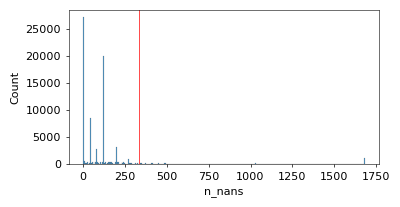

In [341]:
plt.figure(figsize=(4, 2))

sns.histplot(links_binned, x='n_nans')

plt.axvline(allowed_nans_count, c='r')

In [342]:
links_binned_filtered = links_binned.query('n_nans<@allowed_nans_count')
links_binned.query('n_nans>@allowed_nans_count').shape

(3559, 16)

In [344]:
links_binned_filtered .shape

(70342, 16)

# Downstream analysis

In [345]:
import warnings
warnings.filterwarnings("ignore")

In [346]:
def cluster_links(links_binned, n_clusters = 8):
    X = np.array(links_binned['pileup'].to_list())
    X = X.reshape(X.shape[0], -1)
    X = np.nan_to_num(X, 0)

    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(X)
    links_binned['pileup_cluster_raw'] = [f'c{l}' for l in labels]
    return links_binned

def plot_links_clusters(links_binned, 
                        cluster_col='pileup_cluster_raw',
                        n_clusters=8, nrows=1,
                        v=0.4, figsize=None, dpi=150,
                        cbar=True,
                       ):
    ncols = min([n_clusters // nrows, n_clusters])
    if nrows * ncols < n_clusters:
         ncols += 1
    if figsize is None:
        figsize = (n_clusters*1.2, 2*nrows)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharey=True, layout='tight',
                           figsize=figsize, dpi=dpi)
    plt.subplots_adjust(wspace=0)
    axs = axs.ravel()

    for i, (cluster, data) in enumerate(links_binned.groupby(cluster_col)):
        ax = axs[i]
        
        mtx = np.nanmean(np.array(data['pileup'].to_list()), axis=0)
        
        kwargs = {}
        if v is not None:
            v_val = v[i] if isinstance(v, list) else v
            kwargs['vmin'] = -v_val
            kwargs['vmax'] = v_val
            
        im  = ax.imshow(
                        np.log2(mtx),
                        cmap='coolwarm',
                        **kwargs
        )
        if cbar:
            divider = make_axes_locatable(ax)
            ax_cb = divider.append_axes("right", size="5%", pad=0.05)
            fig.add_axes(ax_cb)

            plt.colorbar(im , label = 'log2 mean obs/exp', cax=ax_cb, )
        
        ticks_pixels = np.linspace(0, flank*2//resolution, 3)
        ticks_pixels = np.linspace(0, flank*2//resolution, 5)
        ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)

        ax.set_xticks(ticks_pixels[1:-1], ticks_kbp[1:-1])
        if i == 0:
            ax.set_xlabel('Distance from gene\nto peak, kbp')

        if i in [0]:
            ax.set_yticks(ticks_pixels[1:-1], ticks_kbp[1:-1])
            ax.set_ylabel('Distrance from link, kbp')

        ax.set_title(f'{cluster}\n{len(data)} links')  
    
    return axs


def plot_links_scatter(links_binned, 
                       cluster_col='pileup_cluster_raw',
                       n_clusters=8,
                       xlim=flank*1.1
                       ):
    fig, axs = plt.subplots(ncols=n_clusters, nrows=1, sharey=True, layout='tight',
                           figsize=(n_clusters*3, 2))
    axs = axs.ravel()

    for i, (cluster, data) in enumerate(links_binned.groupby(cluster_col)):
        ax = axs[i]

        sns.scatterplot(data, x='dist_signed_raw', y='zscore', ax=ax, ec='k',
                       fc='lightblue', s=10)

        ax.set_xlabel('Distance from gene to peak, kbp')
        ax.set_xlim((-xlim, xlim))
        ax.xaxis.set_major_formatter(lambda x, pos: str(int(x/1000)))
        ax.set_title(f'{cluster}\n{len(data)} links')
    
    return axs

def plot_links_hist(links_binned, 
                       cluster_col='pileup_cluster_raw',
                       n_clusters=8, nrows=1,
                       xlim=flank*1.1,
                       seaborn=False,
                       nbins=1000, figsize=None, dpi=150,
                       ):
    ncols = min([n_clusters // nrows, n_clusters])
    if nrows * ncols < n_clusters:
         ncols += 1
    if figsize is None:
        figsize = (n_clusters*3, 2*nrows)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharey=True, layout='tight',
                           figsize=figsize, dpi=dpi)
    axs = axs.ravel()
    
    bins = np.linspace(-20_000_000, 20_000_000, nbins)

    for i, (cluster, data) in enumerate(links_binned.groupby(cluster_col)):
        ax = axs[i]

        if seaborn:
            sns.histplot(data, x='dist_signed_raw', ax=ax, ec='k',
                          bins=bins, fc='lightblue')
        else:
            ax.hist(data.dist_signed_raw, bins=bins)
        
        if i == 0:
            ax.set_xlabel('Distance from gene to peak, kbp')
        ax.set_xlim((-xlim, xlim))
        ax.xaxis.set_major_formatter(lambda x, pos: str(int(x/1000)))
        ax.set_title(f'{cluster}\n{len(data)} links')
    
    return axs

## Close links

In [347]:
links_binned_close = links_binned_filtered.query('dist<=@flank')
links_binned_close = cluster_links(links_binned_close, )

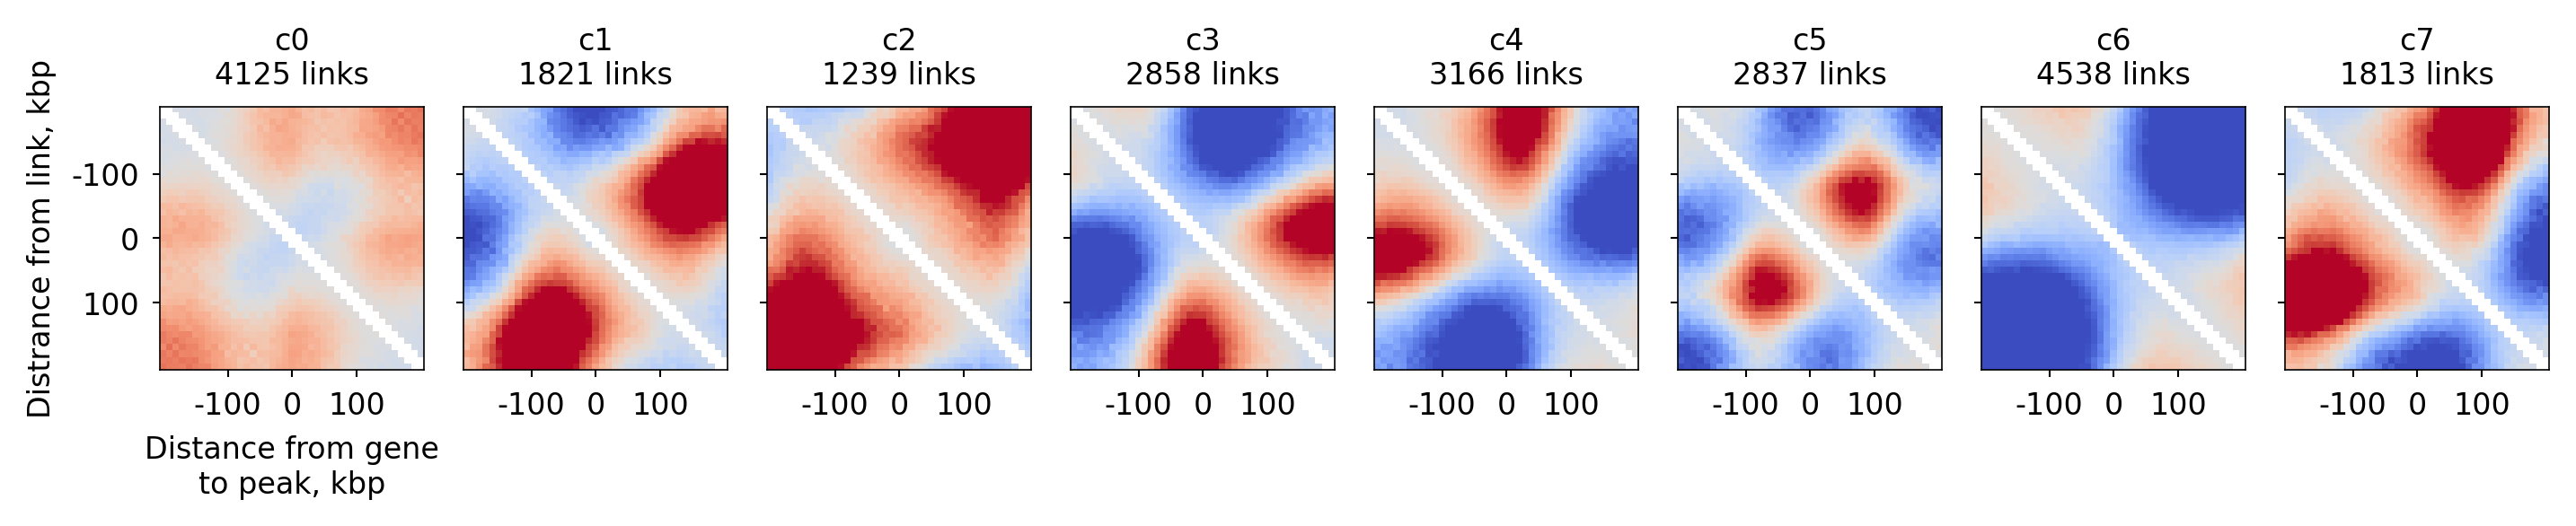

In [348]:
plot_links_clusters(links_binned_close, cluster_col='pileup_cluster_raw', n_clusters=8, cbar=False, dpi=300, v=0.5);

In [349]:

close_clusters = {
    'c6': 'Border',
    'c4': 'Left',
    'c7': 'Left',
    'c2': 'Central',
    'c3': 'Right',
    'c1': 'Right',
    'c0': 'Framed',
    'c5': 'Central compact',
}
cluster_names = list(dict.fromkeys( list(close_clusters.values()) ))

links_binned_close['pileup_cluster'] = links_binned_close.pileup_cluster_raw.map(close_clusters).astype(pd.CategoricalDtype(cluster_names, ordered=True))

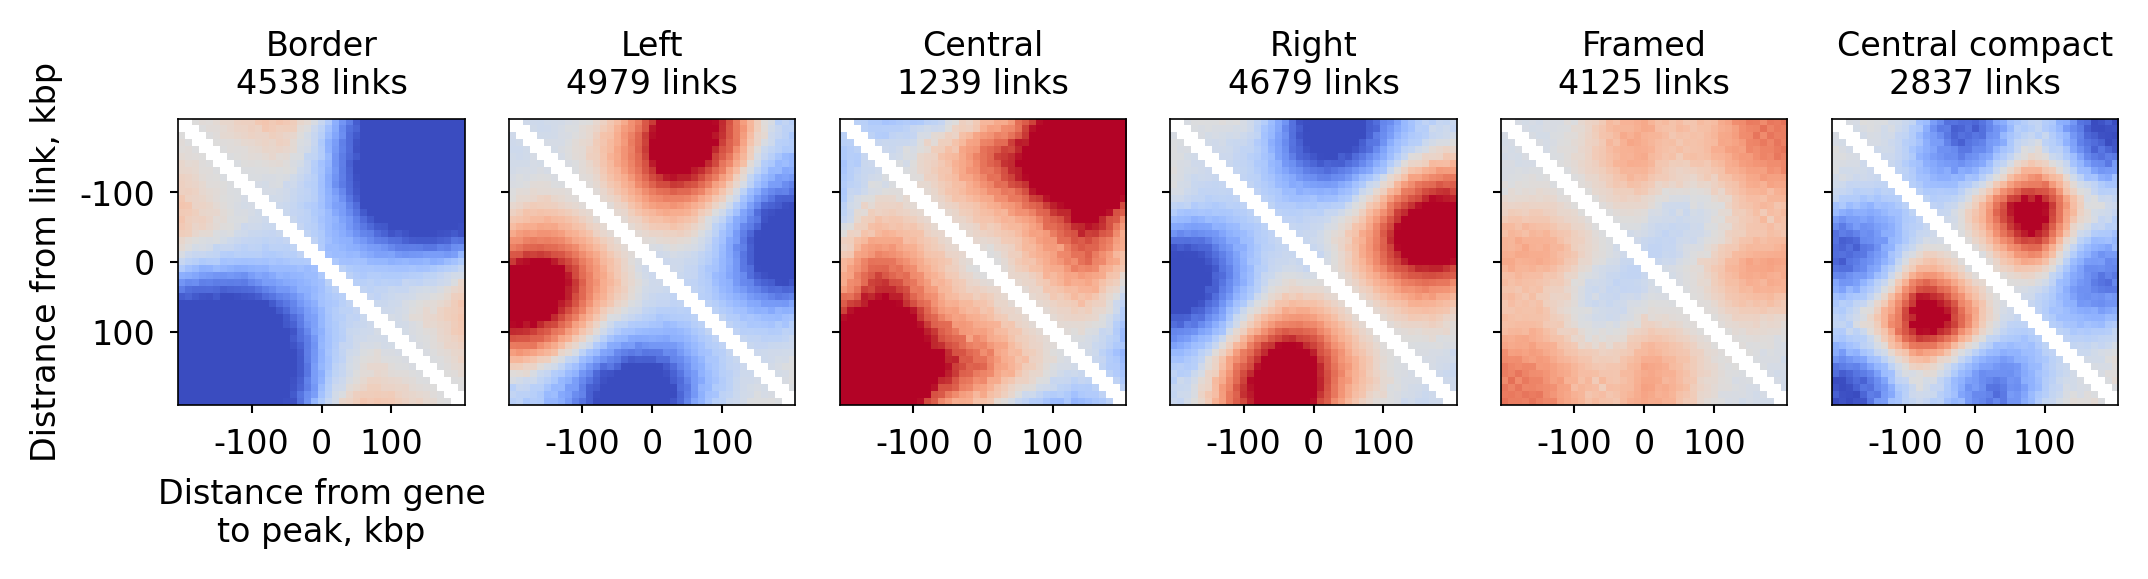

In [350]:
plot_links_clusters(links_binned_close, cluster_col='pileup_cluster', n_clusters=6, cbar=False, dpi=300, v=0.5);
plt.savefig('figures/1_CloseLinks_1_pileups.pdf')

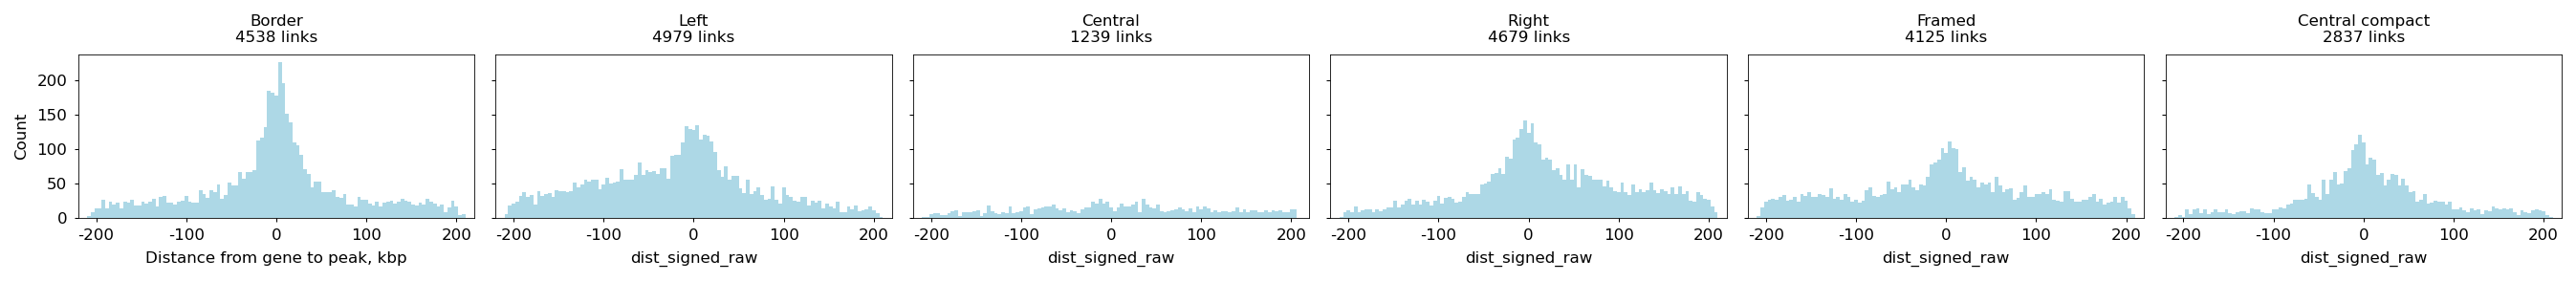

In [352]:
plot_links_hist(links_binned_close, cluster_col='pileup_cluster', n_clusters=6, nbins=10000, seaborn=True);
# plt.savefig('figures/1_CloseLinks_3_histogram.pdf')

## Distal links

In [353]:
links_binned_distal = links_binned_filtered.query('dist>@flank')
links_binned_distal = cluster_links(links_binned_distal, n_clusters=8)

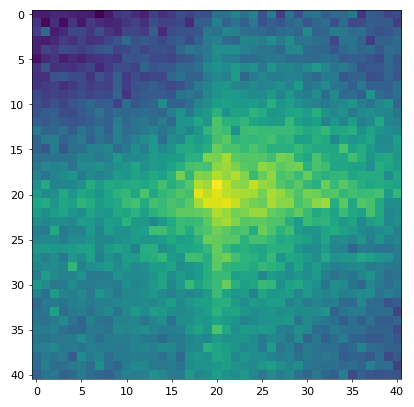

In [354]:
plt.imshow(np.nanmean(np.stack(links_binned_distal.pileup.to_numpy()), axis=0))

In [355]:
def classify_loop(matrix: np.ndarray) -> bool:
    n = matrix.shape[0]
    
    if np.all(matrix < 0):
        return "depleted"        

    inner = matrix[ n//2 : n//2+1 ,  n//2: n//2+1 ]
    inner = matrix[ :  ,  : ]
    norm = np.mean(matrix)# - np.mean(inner)
    
    inner = matrix[ n//2-n//3 : n//2+n//3+1 , n//2-n//3 : n//2+n//3+1]
    norm = np.mean([np.mean(matrix[n//2+n//4:, :n//4+1]),
                    np.mean(matrix[:n//4+1, :n//4+1]),
                    np.mean(matrix[:n//4+1, n//2+n//4:]),
                    np.mean(matrix[n//2+n//4:, n//2+n//4:])
                   ])
                    
    
    fc = 1.2
    if (np.mean(inner)  > fc) and (np.mean(inner) / norm  > 1):
        return 'loop'

    return "depleted"

In [356]:
links_binned_distal['cluster'] = links_binned_distal.pileup.apply(classify_loop)

In [357]:
links_binned_distal['cluster2'] = links_binned_distal['cluster'] +  links_binned_distal['pileup_cluster_raw']
pd.crosstab(links_binned_distal['cluster'], links_binned_distal['pileup_cluster_raw'])

pileup_cluster_raw,c0,c1,c2,c3,c4,c5,c6,c7
cluster,,,,,,,,
depleted,3,17019,15762,4146,2,1661,286,5321
loop,3,25,0,840,0,1208,367,1302


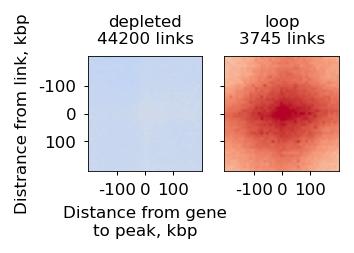

In [41]:
plot_links_clusters(links_binned_distal, v=1, cluster_col='cluster', n_clusters=2, cbar=False);
plt.savefig('figures/1_DistalLinks_1_pileups.pdf')

# Check examples

In [48]:
links_anno = links_binned_filtered.merge(links_binned_distal[['region_gene', 'region_peak', 'cluster']], how='left')
links_anno = links_anno.merge(links_binned_close[['region_gene', 'region_peak', 'pileup_cluster']], how='left')
links_anno['cluster'] = links_anno['cluster'].fillna(links_anno['pileup_cluster'])
links_anno = links_anno.drop(['pileup_cluster'], axis=1)

In [49]:
def save_links(links, file):
    links = links[['peak_chrom', 'peak_start', 'peak_end', 'gene_chrom', 'gene_start', 'gene_end']]
    links.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']
    links.to_csv(file, sep='\t', index=False)    

In [50]:
# genes_of_interest = 'ALX1, MSX1, PRRX1, PAX1, IRF6, FOXL2, PAX3, TFAP2B, TFAP2D'.split(', ')
# save_links(links_anno.query('gene.isin(@genes_of_interest)'), 
#            'pygenometracks/links.links')
# save_links(links_anno.query('gene.isin(@genes_of_interest)').query('cluster=="loop"'), 
#            'pygenometracks/links_loop.links')
# save_links(links_anno.query('gene.isin(@genes_of_interest)').query('cluster=="depleted"'), 
#            'pygenometracks/links_depl.links')
# save_links(links_anno.query('gene.isin(@genes_of_interest)').query('dist<@flank'), 
#            'pygenometracks/links_prox.links')

In [51]:
genes_to_plot = reference[['chr', 'start', 'end','gene']]#.to_csv('pygenometracks/genes.bed', sep='\t', index=False, header=None)
genes_to_plot['length'] = genes_to_plot.end - genes_to_plot.start

# genes_to_plot.groupby('gene').agg({'start': 'min', 'end':'max', 'chr': lambda xs: list(xs)[0]}).reset_index()[['chr', 'start', 'end','gene']].to_csv('pygenometracks/genes.bed', sep='\t', index=False, header=None)
(
genes_to_plot.sort_values(by=['gene', 'length'], ascending=False)
    .drop_duplicates(subset='gene', keep='first')
    .sort_values(by=['chr', 'start'])[['chr', 'start', 'end','gene']]
    .query('not gene.str.startswith("LINC")')
    .query('not gene.str.startswith("LOC")')
    .query('not gene.str.startswith("MIR")')
    .query('not (gene.str.startswith("C") and gene.str.contains("orf"))')
    .query('not gene.str.endswith("-AS1")')
    .query('not gene.str.endswith("-AS2")')
    .query('not gene.str.endswith("-OT")')    
    .to_csv('pygenometracks/genes.bed', sep='\t', index=False, header=None)
    
)

In [58]:
extra_beds = pd.DataFrame({'chr': {0: 'chr20'},
 'start': {0: 21682293},
 'end': {0: 21683246},
 'gene': {0: 'Mutated enhancer'}
})

extra_beds.to_csv('pygenometracks/extra_to_plot.bed', sep='\t', index=False, header=None)

In [59]:
links_anno.query('gene == "PAX1"').head(1)

,gene_chrom,gene_start,gene_end,peak_chrom,peak_start,peak_end,gene,region_gene,region_peak,id,same_bin,dist,dist_signed,dist_signed_raw,pileup,n_nans,cluster
40519,chr20,21710000,21720000,chr20,18730000,18740000,PAX1,chr20-21712072-21712073,chr20-18739446-18739447,28094,False,2980000,2980000,2972626,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",121,depleted


# Annotate clusters

In [98]:
clusters_map = links_anno[['id', 'cluster', 'gene']].drop_duplicates().set_index(['id', 'gene'])['cluster'].str.capitalize().to_dict()

links_raw_anno = links_raw.copy()
links_raw_anno['HiC_Cluster'] = links_raw.apply(lambda x: clusters_map.get((x.name, x.gene)), axis=1)
links_raw_anno['HiC_Cluster'] = links_raw_anno['HiC_Cluster'].apply(lambda x: {'Depleted':'No loop'}.get(x, x))

# Annotate domain boundaries

In [109]:
boundaries = pd.read_csv('Domaion_boundaries_100kb.csv', index_col=0)

In [128]:
def is_boundary_inbetween(link, boundaries=boundaries):
    chrom = link['peak_chrom']
    gs, ge = link['gene_start'], link['gene_end']
    ps, pe = link['peak_start'], link['peak_end']    
    
    if ps < gs:
        start, end = pe, gs
    elif gs < ps:
        start, end = ge, ps
        
    boundaries_between = boundaries.query('chrom==@chrom').query('@start <= pos <= @end')
    return len(boundaries_between) > 0

In [140]:
%%time 

boundaries_between = links_anno.apply(is_boundary_inbetween, axis=1)

CPU times: user 7min 21s, sys: 43.6 s, total: 8min 5s
Wall time: 6min 37s


In [146]:
links_anno['is_boundary_inbetween'] = boundaries_between
boundary_map = links_anno[['id', 'is_boundary_inbetween', 'gene']].drop_duplicates().set_index(['id', 'gene'])['is_boundary_inbetween'].to_dict()
links_raw_anno['is_boundary_inbetween'] = links_raw.apply(lambda x: boundary_map.get((x.name, x.gene)), axis=1)

In [205]:
df_for_plot = links_raw_anno.copy()
df_for_plot['length'] = df_for_plot.Link_end - df_for_plot.Link_start
cat = pd.CategoricalDtype(['Border', 'Left', 'Central', 'Right',   'Framed', 'Central compact',  'No loop', 'Loop'], ordered=True)
df_for_plot['HiC_Cluster_cat'] = df_for_plot['HiC_Cluster'].astype(cat)

<Axes: xlabel='length', ylabel='PhastCons_Avg'>

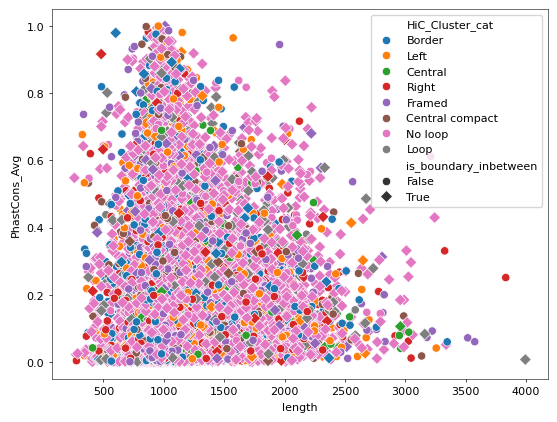

In [206]:
sns.scatterplot(data=df_for_plot.dropna(subset='is_boundary_inbetween'), 
                x='length', y='PhastCons_Avg',
               hue='HiC_Cluster_cat', style='is_boundary_inbetween',
               markers=['o', 'D'])

In [306]:
df_stats = df_for_plot.dropna(subset='is_boundary_inbetween')

stats = {}
for cluster, data in df_stats.groupby('HiC_Cluster'):
    test = pg.mwu(data.query('is_boundary_inbetween == True').PhastCons_Avg, 
              data.query('is_boundary_inbetween == False').PhastCons_Avg, 
              alternative='two-sided')
    
    stats[cluster] = test['p-val']['MWU']
    
reject, pvals_corr = pg.multicomp(list(stats.values()), method='fdr_bh')
stats = dict(zip(stats.keys(), pvals_corr))

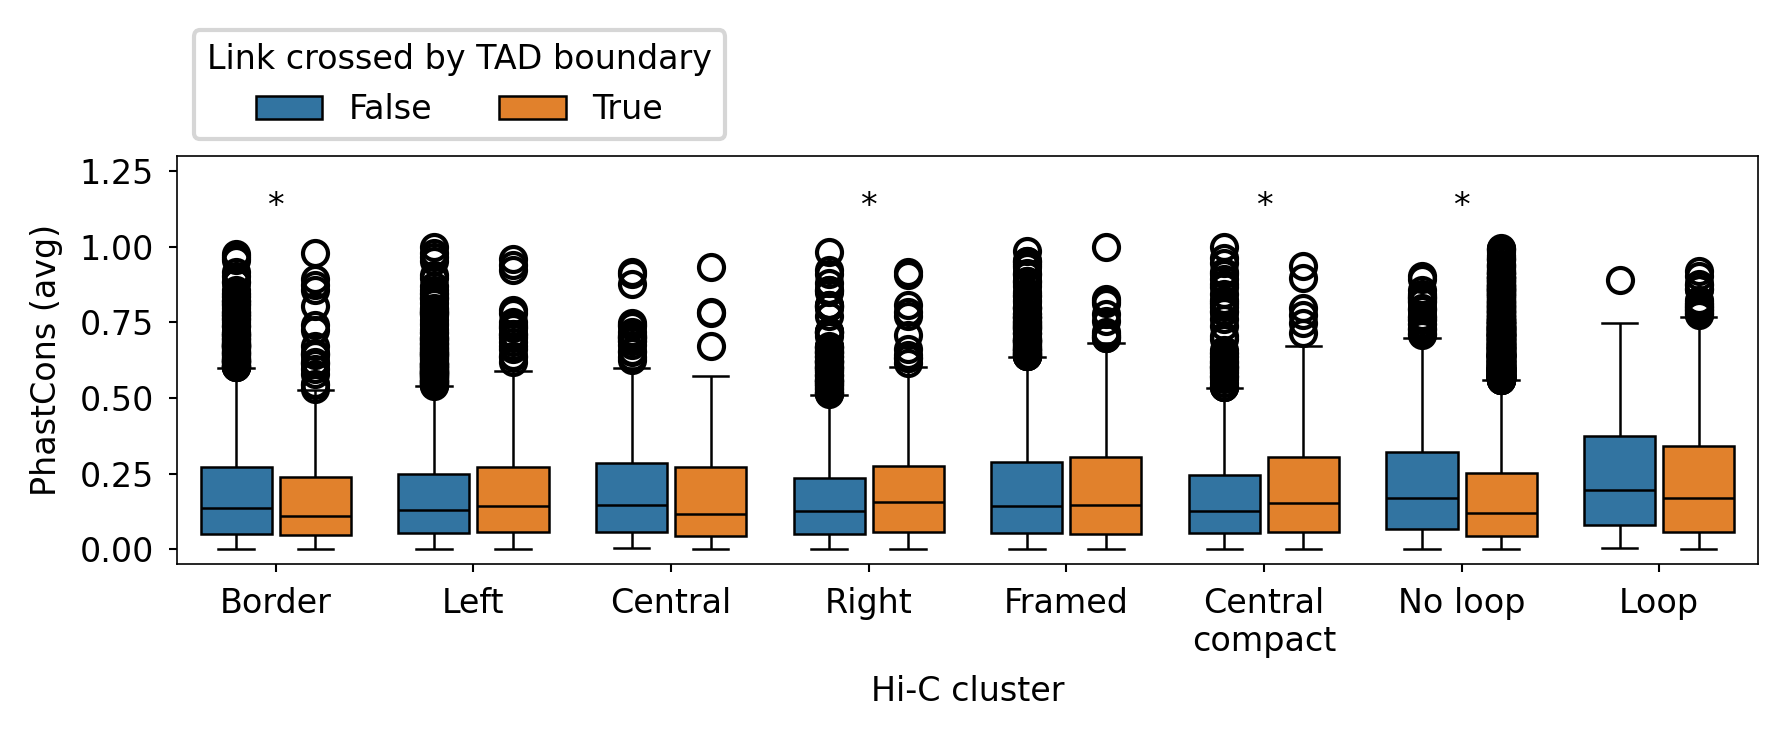

In [315]:
plt.figure(figsize=(6, 2.5), dpi=300, layout='tight')
sns.boxplot(data=df_for_plot.dropna(subset='is_boundary_inbetween'), 
            x='HiC_Cluster_cat', y='PhastCons_Avg', hue='is_boundary_inbetween',
            gap=.1, linecolor='k', linewidth=0.6,
            )

plt.legend(ncols=3, bbox_to_anchor=(0,1), loc='lower left', title='Link crossed by TAD boundary')
plt.xlabel('Hi-C cluster')
plt.ylabel('PhastCons (avg)')

xticklabels = plt.gca().get_xticklabels()

for i, xlabel in enumerate(xticklabels):
    pval = stats[xlabel._text]
    s = '*' if pval < 0.05 else ''
    plt.text(x=i, y=1.1, s=s, ha='center')
xticklabels[5]._text = xticklabels[5]._text.replace(' ', '\n')
plt.gca().set_xticklabels(xticklabels)

plt.ylim(-0.05, 1.3)
# plt.layout('tight')
plt.savefig('figures/1_2_PhastCons_comparison.pdf')

# Save

In [150]:
links_raw_anno.to_csv('Final_Table_4_lead_conserv_with_hic_cluster_and_boundaries.csv', index=0)